<a href="https://colab.research.google.com/github/Ananda-2/6-Age-Calculator/blob/main/Indoor_Scene_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indoor Scene Recognition

The dataset has a collection of about 15000+ labeled images belonging to 67 categories. I am selecting only below 10 categories ⚰

airport_inside, auditorium, bakery, bathroom, bookstore, casino, church_inside, grocerystore, operating_room, warehouse

Objective is to create a model that will able to classify images into these 10 categories.


## Importing required libraries


In [1]:
# Importing required libraries
import os
import pathlib
import math
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
np.random.seed(42)
import random as rn
rn.seed(42)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(42)
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, GlobalMaxPool3D, BatchNormalization, Dropout, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
# Checking available Nvidia GPU
!nvidia-smi

Wed Mar 19 06:36:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Preparing data

In [ ]:
# # Unzip files
# from zipfile import ZipFile

# with ZipFile('/content/drive/MyDrive/colab_data/indoorCVPR/data_10_cats.zip', 'r') as zipobj:
#     zipobj.extractall('/content/drive/MyDrive/colab_data/indoorCVPR')
#     print('Files are unzipped')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I have considered below 10 categories for classification:
airport_inside, auditorium, bakery, bathroom, bookstore, casino, church_inside, grocerystore, operating_room, warehouse

### Spliting data for training and validation

In [ ]:
# Training dataset path
data_path = '/content/drive/My Drive/archive/indoorCVPR_09/Images'
train_data_dir = pathlib.Path(data_path)

# Counting the number of images
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(f"Total images: {image_count}")

Total images: 2983


In [ ]:
# Setting image height, width and batch size
img_height= 150
img_width= 150
batch_size= 64

In [ ]:
# Training dataset
train_ds= tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, seed= 42, validation_split= 0.2,
                                                              subset= 'training',
                                                              batch_size= batch_size,
                                                              image_size= (img_height, img_width)
                                                              )

Found 2985 files belonging to 10 classes.
Using 2388 files for training.


In [ ]:
# Validation dataset
val_ds= tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, seed= 42, validation_split= 0.2,
                                                              subset= 'validation',
                                                              batch_size= batch_size,
                                                              image_size= (img_height, img_width)
                                                              )

Found 2985 files belonging to 10 classes.
Using 597 files for validation.


### Vizualizing training data

In [ ]:
# Checking all class names
class_names = train_ds.class_names
print(class_names)

['auditorium', 'bathroom', 'bedroom', 'elevator', 'gym', 'kitchen', 'library', 'office', 'restaurant', 'stairscase']


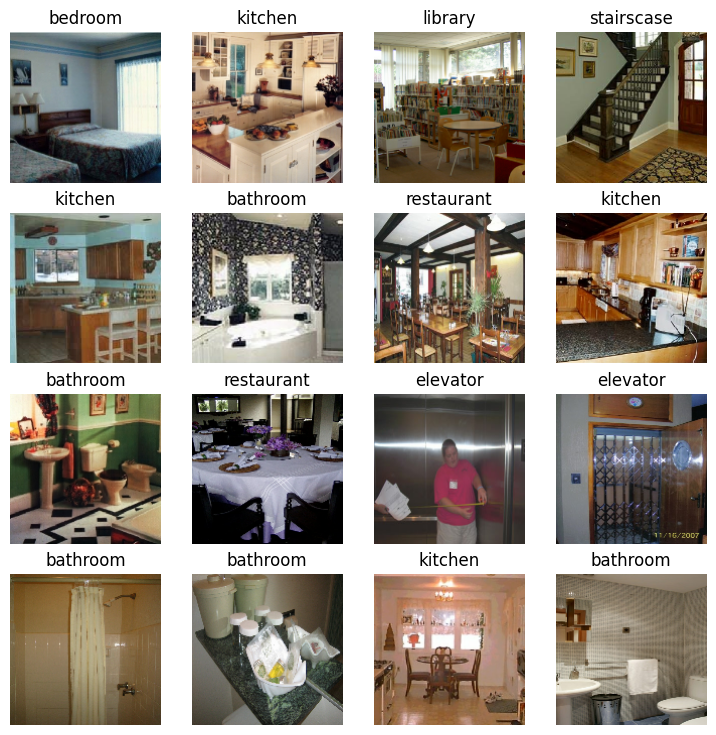

In [ ]:
# Checking training data
plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

### Data Augmentation

Now, creating data augmentation layer. I have selected only relevant data augmentation techniques for current scenario.

In [ ]:
# ## Creating data augmentation layer
augmentation_layer= Sequential(
  [tf.keras.layers.InputLayer(input_shape= (img_height, img_width, 3)),
   tf.keras.layers.RandomFlip('horizontal', seed= 42),
   tf.keras.layers.RandomRotation(0.2, fill_mode= 'wrap', seed= 42),
   tf.keras.layers.RandomZoom(0.2, seed= 42),
   tf.keras.layers.RandomTranslation(.2, .2, fill_mode='wrap', interpolation='bilinear', seed= 42),
   tf.keras.layers.RandomContrast(0.2, seed= 42)]
   )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


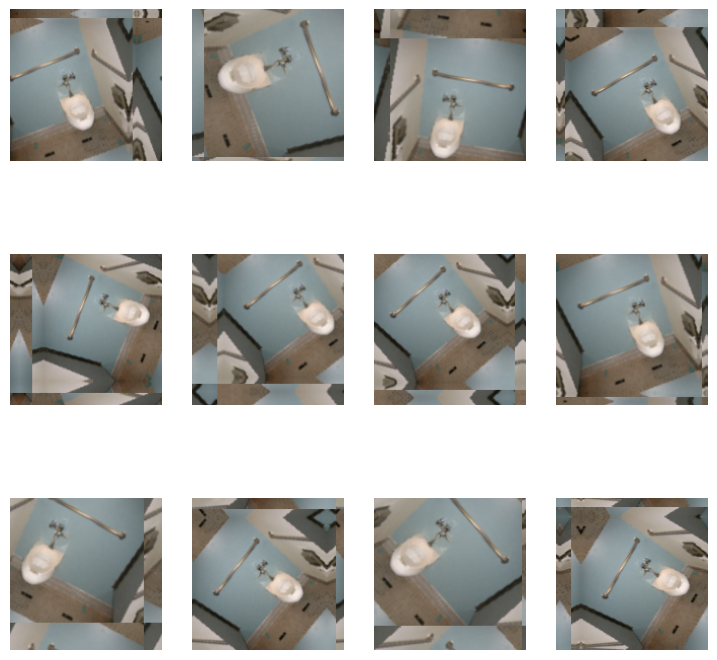

In [ ]:
# Plotting different augmented version of a random image from training dataset
plt.figure(figsize=(9, 9))
a= np.random.randint(42)
for images, labels in train_ds.take(1):
    for i in range(12):
      aug_img= augmentation_layer(images)
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(aug_img[a].numpy().astype(np.int32))
      plt.axis('off')

## Model building

### InceptionV3 Finetuning

First trying transfer learning using InceptionV3 architecture with imagenet pretrained weights. I have removed the default output softmax layer of InceptionV3. I have kept First 249 layers weights as it is. Trained layer 249 to last layer on training dataset. Added a Flatten layer, Dropout layers, 2 hidden dense layers and output dense layer with 10 neurons and softmax as activation.

I will use label encoding instead of one hot encoding to optimize memory utilization. So my loss function will be: sparse_categorical_entropy and my metric will be sparse_categorical_accuracy.

In [ ]:
# Creating function to fine tune InceptionV3
def inceptionv3(inp_shape, dropout_rate, train_layers_after):
    inceptionv3= InceptionV3(weights= 'imagenet', include_top= False)
    for layer in inceptionv3.layers[:train_layers_after]:
      layer.trainable= False
    input_layer= Input(shape= inp_shape)
    data_aug_layer= augmentation_layer(input_layer)
    norm_layer= tf.keras.layers.Rescaling(1./255)(data_aug_layer)
    cnn_layers= inceptionv3(norm_layer)
    flatten_layer= Flatten()(cnn_layers)
    dropout_layer1= Dropout(dropout_rate)(flatten_layer)
    dense_layer= Dense(1024, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    dense_layer_1= Dense(512, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer2)
    dropout_layer3= Dropout(dropout_rate)(dense_layer_1)
    output_layer= Dense(10, activation= 'softmax')(dropout_layer3)
    model= Model(input_layer, output_layer)
    model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['sparse_categorical_accuracy'])
    return model

In [ ]:
# Creating model
inp_shape= (150, 150, 3)
dropout_rate= .25
train_layers_after= 249
incv3_model= inceptionv3(inp_shape, dropout_rate, train_layers_after)
incv3_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 3, 3, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      18,875,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,208,106 (157.20 MB)

 Trainable params: 30,520,202 (116.43 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [ ]:
# Loading data into cache to overcome data bottleneck during training.
AUTOTUNE= tf.data.AUTOTUNE
AUTOTUNE= tf.data.experimental.AUTOTUNE

# Shuffling data before starting of each epoch
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
val_ds= val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [ ]:
# Setting callbacks

base_path= '/content/drive/MyDrive/colab_data/indoorCVPR/models/'

filepath= base_path + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

checkpoint= ModelCheckpoint(filepath, monitor= 'val_sparse_categorical_accuracy', verbose= 1,
                            save_best_only= True, save_weights_only= False, mode= 'auto')

LR= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience= 30, verbose= 1)
callbacks_list= [checkpoint, LR]

In [ ]:
# Model training
epochs= 10
steps_per_epoch= math.ceil(2652/batch_size)
validation_steps= math.ceil(663/batch_size)

history= incv3_model.fit(train_ds, validation_data= val_ds, steps_per_epoch= steps_per_epoch, epochs= epochs, callbacks= callbacks_list, validation_steps= validation_steps)

Epoch 1/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 33.2874 - sparse_categorical_accuracy: 0.2809

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.36683, saving model to /content/drive/MyDrive/colab_data/indoorCVPR/models/model-00001-27.06052-0.37228-26.94345-0.36683.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - loss: 32.6943 - sparse_categorical_accuracy: 0.2896 - val_loss: 26.9434 - val_sparse_categorical_accuracy: 0.3668 - learning_rate: 0.0010
Epoch 2/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 14.4362 - sparse_categorical_accuracy: 0.5841
Epoch 2: val_sparse_categorical_accuracy improved from 0.36683 to 0.73367, saving model to /content/drive/MyDrive/colab_data/indoorCVPR/models/model-00002-12.29523-0.62270-8.74437-0.73367.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - loss: 14.2323 - sparse_categorical_accuracy: 0.5878 - val_loss: 8.7444 - val_sparse_categorical_accuracy: 0.7337 - learning_rate: 0.0010
Epoch 3/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 7.6879 - sparse_categorical_accuracy: 0.6920
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.73367
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 7.6115 - sparse_categorical_accuracy: 0.6927 - val_loss: 5.6259 - val_sparse_categorical_accuracy: 0.7119 - learning_rate: 0.0010
Epoch 4/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 4.9316 - sparse_categorical_accuracy: 0.7399
Epoch 4: val_sparse_categorical_accuracy did not improve from 0.73367
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 4.9020 - sparse_categorical_accuracy: 0.7388 - val_loss: 4.1498 - val_sparse_categorical_accuracy: 0.7119 - learning_rate: 0.0010
Epoch 5/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 3.6988 - sparse_categorical_accuracy: 0.7542
Epoch 5

42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 3.6782 - sparse_categorical_accuracy: 0.7547 - val_loss: 3.1295 - val_sparse_categorical_accuracy: 0.7755 - learning_rate: 0.0010
Epoch 6/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 2.8905 - sparse_categorical_accuracy: 0.7907
Epoch 6: val_sparse_categorical_accuracy did not improve from 0.77554
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 2.8815 - sparse_categorical_accuracy: 0.7900 - val_loss: 2.7184 - val_sparse_categorical_accuracy: 0.7755 - learning_rate: 0.0010
Epoch 7/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 2.4725 - sparse_categorical_accuracy: 0.7944
Epoch 7: val_sparse_categorical_accuracy did not improve from 0.77554
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 2.4666 - sparse_categorical_accuracy: 0.7935 - val_loss: 2.5217 - val_sparse_categorical_accuracy: 0.7471 - learning_rate: 0.0010
Epoch 8/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 2.1890 - sparse_categorical_accuracy: 0.7966
Epoch 8:

42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step - loss: 1.8824 - sparse_categorical_accuracy: 0.8299 - val_loss: 2.2593 - val_sparse_categorical_accuracy: 0.7772 - learning_rate: 0.0010
Epoch 10/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 1.7231 - sparse_categorical_accuracy: 0.8334
Epoch 10: val_sparse_categorical_accuracy did not improve from 0.77722
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 1.7233 - sparse_categorical_accuracy: 0.8326 - val_loss: 2.1621 - val_sparse_categorical_accuracy: 0.7035 - learning_rate: 0.0010


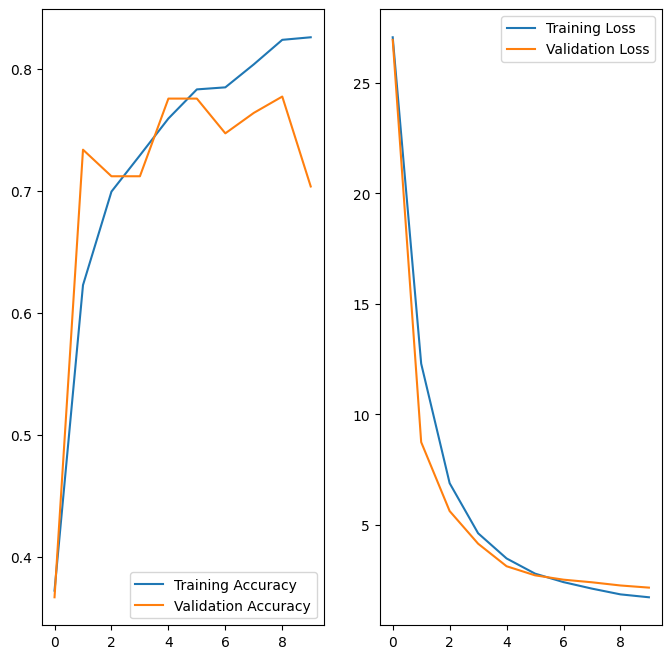

In [ ]:
acc= history.history['sparse_categorical_accuracy']
val_acc= history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

- Best Epoch: 109 (model-00109-0.08159-0.99170-0.67942-0.85068.h5)
- **Training: loss: .08 - categorical_accuracy: 0.99**
- **Validation: val_loss: .68 - val_sparse_categorical_accuracy: 0.85**


### Xception Finetunning

Used almost same architecture as previous one, only used Xception as our cnn architecture instead of InceptionV3. Removed output softmax layer of Xception architecture and finetunned Xception from layer 114 to end layer. Then I have added custom layers as previous.

In [ ]:
# Creating function to fine tune Xception
def xception_cnn(inp_shape, dropout_rate, train_layers_after):
    xcp= Xception(weights= 'imagenet', include_top= False)
    for layer in xcp.layers[:train_layers_after]:
      layer.trainable= False
    input_layer= Input(shape= inp_shape)
    data_aug_layer= augmentation_layer(input_layer)
    norm_layer= tf.keras.layers.Rescaling(1./255)(data_aug_layer)
    cnn_layers= xcp(norm_layer)
    flatten_layer= Flatten()(cnn_layers)
    dropout_layer1= Dropout(dropout_rate)(flatten_layer)
    dense_layer= Dense(1024, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    dense_layer_1= Dense(512, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer2)
    dropout_layer3= Dropout(dropout_rate)(dense_layer_1)
    output_layer= Dense(10, activation= 'softmax')(dropout_layer3)
    model= Model(input_layer, output_layer)
    model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['sparse_categorical_accuracy'])
    return model

In [ ]:
# Creating model
inp_shape= (150, 150, 3)
dropout_rate= .25
train_layers_after= 114
xcp_model= xception_cnn(inp_shape, dropout_rate, train_layers_after)
xcp_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 5, 5, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      52,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,821,234 (281.61 MB)

 Trainable params: 59,749,594 (227.93 MB)

 Non-trainable params: 14,071,640 (53.68 MB)

In [ ]:
# Model training
epochs= 10
steps_per_epoch= math.ceil(2652/batch_size)
validation_steps= math.ceil(663/batch_size)

history= xcp_model.fit(train_ds, validation_data= val_ds, steps_per_epoch= steps_per_epoch, epochs= epochs, callbacks= callbacks_list, validation_steps= validation_steps)

Epoch 1/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - loss: 29.7886 - sparse_categorical_accuracy: 0.2119
Epoch 1: val_sparse_categorical_accuracy did not improve from 0.77722
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 339ms/step - loss: 29.1416 - sparse_categorical_accuracy: 0.2145 - val_loss: 11.5824 - val_sparse_categorical_accuracy: 0.2730 - learning_rate: 0.0010
Epoch 2/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 9.1113 - sparse_categorical_accuracy: 0.2734
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.77722
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 8.9583 - sparse_categorical_accuracy: 0.2752 - val_loss: 5.2107 - val_sparse_categorical_accuracy: 0.3216 - learning_rate: 0.0010
Epoch 3/10
38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 4.8704 - sparse_categorical_accuracy: 0.2964
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.77722
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - loss: 4.8406 - sparse_categorical_accuracy: 0.2961 - val_loss: 3.890

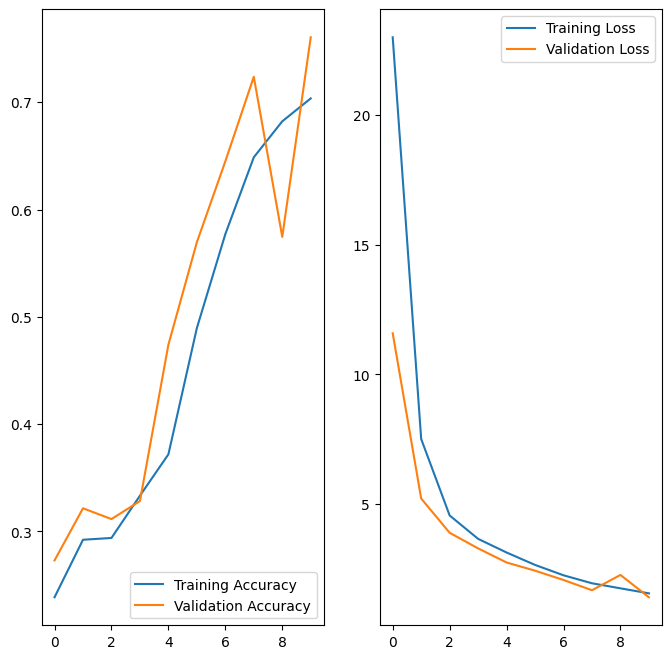

In [ ]:
acc= history.history['sparse_categorical_accuracy']
val_acc= history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
incv3_model.save('/content/drive/MyDrive/colab_data/indoorCVPR/models/inceptionv3_final_model.keras')
xcp_model.save('/content/drive/MyDrive/colab_data/indoorCVPR/models/xception_final_model.keras')

In [ ]:
incv3_model.save('/content/inceptionv3_model.keras')
xcp_model.save('/content/xception_model.keras')

In [ ]:
from google.colab import files

files.download('/content/inceptionv3_model.keras')
files.download('/content/xception_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference Script

In [ ]:
# Combining both the models for inference
final_model1= tf.keras.models.load_model('/content/drive/MyDrive/colab_data/indoorCVPR/models/model-00001-27.06052-0.37228-26.94345-0.36683.h5')
final_model2=  tf.keras.models.load_model('/content/drive/MyDrive/colab_data/indoorCVPR/models/model-00009-1.85698-0.82370-2.25931-0.77722.h5')
models= [final_model1, final_model2]

In [ ]:
# ✅ Define class labels
classes = ['Auditorium', 'Bathroom', 'Bedroom', 'Elevator', 'Gym',
           'Kitchen', 'Library', 'Office', 'Restaurant', 'Staircase']

In [ ]:
from google.colab import files
from google.colab.patches import cv2_imshow  # Display frames in Colab

In [ ]:
# ✅ Mount Google Drive to access model files
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
from google.colab.patches import cv2_imshow  # Display frames in Colab'
import tensorflow as tf

# ✅ Define class labels
classes = ['Auditorium', 'Bathroom', 'Bedroom', 'Elevator', 'Gym',
           'Kitchen', 'Library', 'Office', 'Restaurant', 'Staircase']

# Combining both the models for inference
final_model1= tf.keras.models.load_model('/content/drive/MyDrive/colab_data/indoorCVPR/models/model-00001-27.06052-0.37228-26.94345-0.36683.h5')
final_model2=  tf.keras.models.load_model('/content/drive/MyDrive/colab_data/indoorCVPR/models/model-00009-1.85698-0.82370-2.25931-0.77722.h5')
models= [final_model1, final_model2]



# ✅ Function to process video & predict overall scene
def process_video(video_path, models, sample_rate=10, max_frames=500):
    """Process a video and predict scene based on every few frames."""
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"❌ Video not found: {video_path}")

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    predictions = []  # Store predictions for multiple frames

    if not cap.isOpened():
        print("❌ Error: Could not open video file.")
        return

    while frame_count < max_frames:  # Prevent infinite loop
        ret, frame = cap.read()
        if not ret:
            print("✅ Video processing completed.")
            break  # Exit loop when video ends

        # Process only every 'sample_rate' frames (e.g., every 10 frames)
        if frame_count % sample_rate == 0:
            img = cv2.resize(frame, (150, 150), interpolation=cv2.INTER_AREA)
            img = img.reshape((1, 150, 150, 3))

            # Get predictions from both models
            pred1 = models[0].predict(img)
            pred2 = models[1].predict(img)
            pred = (pred1 + pred2) / 2  # Average prediction

            # Store predicted class index
            predictions.append(np.argmax(pred))

        frame_count += 1

    cap.release()  # Ensure video is properly closed
    cv2.destroyAllWindows()

    # ✅ Determine overall predicted class (most common prediction)
    if predictions:
        overall_class = max(set(predictions), key=predictions.count)
        overall_scene = classes[overall_class]
        print(f"\n🎯 **Overall Predicted Scene: {overall_scene}**")
    else:
        print("❌ No frames processed. Check your video file.")

# ✅ Upload one video, process it, and stop
print("\n📤 Upload a video file...")
uploaded = files.upload()  # Upload one video

video_path = list(uploaded.keys())[0]  # Get uploaded video name
print(f"\n🎬 Processing: {video_path}")
process_video(video_path, models)  # Process video

print("\n✅ Done! Processed one video and stopped.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



📤 Upload a video file...


Saving mixkit-office-elevator-with-a-green-screen-20828-hd-ready.mp4 to mixkit-office-elevator-with-a-green-screen-20828-hd-ready.mp4

🎬 Processing: mixkit-office-elevator-with-a-green-screen-20828-hd-ready.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/

In [ ]:
!pip install gTTs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
from google.colab.patches import cv2_imshow  # Display frames in Colab
from gtts import gTTS  # Text-to-Speech
import IPython.display as ipd  # Play audio in Colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ✅ Define class labels
class_labels = ['Auditorium', 'Bathroom', 'Bedroom', 'Elevator', 'Gym',
           'Kitchen', 'Library', 'Office', 'Restaurant', 'Staircase']

# Combining both the models for inference
final_model1= tf.keras.models.load_model('/content/drive/MyDrive/colab_data/indoorCVPR/models/model-00001-27.06052-0.37228-26.94345-0.36683.h5')
final_model2=  tf.keras.models.load_model('/content/drive/MyDrive/colab_data/indoorCVPR/models/model-00009-1.85698-0.82370-2.25931-0.77722.h5')
models= [final_model1, final_model2]



In [ ]:
from collections import Counter


📤 Upload a video file...


Saving 3371015-hd_1920_1080_30fps.mp4 to 3371015-hd_1920_1080_30fps (7).mp4

🎬 Processing: 3371015-hd_1920_1080_30fps (7).mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


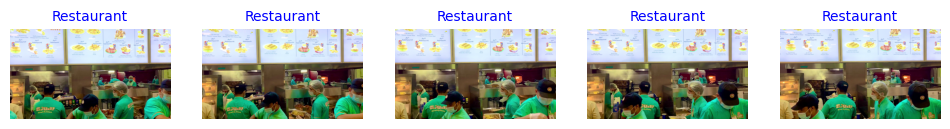


🎯 **Final Predicted Scene: Restaurant**



✅ Done! Processed one video and stopped.


In [ ]:
def process_video(video_path, models, sample_rate=10, max_frames=500):
    """Process a video, predict scene every few frames, and determine the overall scene."""
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"❌ Video not found: {video_path}")

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    predictions = []  # Store predictions for multiple frames
    sample_frames = []  # Store a few sample frames

    if not cap.isOpened():
        print("❌ Error: Could not open video file.")
        return

    while frame_count < max_frames:  # Prevent infinite loop
        ret, frame = cap.read()
        if not ret:
            print("✅ Video processing completed.")
            break  # Exit loop when video ends

        # Process only every 'sample_rate' frames (e.g., every 10 frames)
        if frame_count % sample_rate == 0:
            img = cv2.resize(frame, (150, 150), interpolation=cv2.INTER_AREA)
            img = img.reshape((1, 150, 150, 3))

            # Get predictions from both models
            pred1 = models[0].predict(img)
            pred2 = models[1].predict(img)
            pred = (pred1 + pred2) / 2  # Average prediction

            # Store predicted class index
            predictions.append(np.argmax(pred))

            # Store some sample frames for display
            if len(sample_frames) < 5:  # Show first 5 frames
                sample_frames.append((frame, classes[np.argmax(pred)]))

        frame_count += 1

    cap.release()  # Ensure video is properly closed
    cv2.destroyAllWindows()

    # ✅ Show a few sample frames with predictions
    if sample_frames:
        plt.figure(figsize=(12, 5))
        for i, (frame, label) in enumerate(sample_frames):
            plt.subplot(1, len(sample_frames), i+1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(label, fontsize=10, color="blue")
            plt.axis("off")
        plt.show()

    # ✅ Determine overall predicted class (most common prediction)
    if predictions:
        overall_class = max(set(predictions), key=predictions.count)
        overall_scene = classes[overall_class]
        print(f"\n🎯 **Final Predicted Scene: {overall_scene}**")

        # ✅ Generate & Play Voice Output
        text = f"This is a {overall_scene}"
        tts = gTTS(text=text, lang="en")  # Convert text to speech
        audio_path = "/content/scene_prediction.mp3"
        tts.save(audio_path)  # Save audio
        ipd.display(ipd.Audio(audio_path, autoplay=True))  # Play audio
        os.remove(audio_path)  # Clean up after playing
    else:
        print("❌ No frames processed. Check your video file.")

# ✅ Upload a video, process it, and stop
print("\n📤 Upload a video file...")
uploaded = files.upload()  # Upload one video

video_path = list(uploaded.keys())[0]  # Get uploaded video name
print(f"\n🎬 Processing: {video_path}")
process_video(video_path, models)  # Process video

print("\n✅ Done! Processed one video and stopped.")


In [ ]:
# # ✅ Function to process video & predict overall scene
# def process_video(video_path, models, sample_rate=10, max_frames=500):
#     """Process a video and predict scene based on every few frames."""
#     if not os.path.exists(video_path):
#         raise FileNotFoundError(f"❌ Video not found: {video_path}")

#     cap = cv2.VideoCapture(video_path)
#     frame_count = 0
#     predictions = []  # Store predictions for multiple frames

#     if not cap.isOpened():
#         print("❌ Error: Could not open video file.")
#         return

#     while frame_count < max_frames:  # Prevent infinite loop
#         ret, frame = cap.read()
#         if not ret:
#             print("✅ Video processing completed.")
#             break  # Exit loop when video ends

#         # Process only every 'sample_rate' frames (e.g., every 10 frames)
#         if frame_count % sample_rate == 0:
#             img = cv2.resize(frame, (150, 150), interpolation=cv2.INTER_AREA)
#             img = img.reshape((1, 150, 150, 3))

#             # Get predictions from both models
#             pred1 = models[0].predict(img)
#             pred2 = models[1].predict(img)
#             pred = (pred1 + pred2) / 2  # Average prediction

#             # Store predicted class index
#             predictions.append(np.argmax(pred))

#         frame_count += 1

#     cap.release()  # Ensure video is properly closed
#     cv2.destroyAllWindows()

#     # ✅ Determine overall predicted class (most common prediction)
#     if predictions:
#         overall_class = max(set(predictions), key=predictions.count)
#         overall_scene = classes[overall_class]
#         print(f"\n🎯 **Overall Predicted Scene: {overall_scene}**")

#         # ✅ Generate & Play Voice Output
#         text = f"This is a {overall_scene}"
#         tts = gTTS(text=text, lang="en")  # Convert text to speech
#         audio_path = "/content/scene_prediction.mp3"
#         tts.save(audio_path)  # Save audio
#         ipd.display(ipd.Audio(audio_path, autoplay=True))  # Play audio
#         os.remove(audio_path)  # Clean up after playing
#     else:
#         print("❌ No frames processed. Check your video file.")

# # ✅ Upload one video, process it, and stop
# print("\n📤 Upload a video file...")
# uploaded = files.upload()  # Upload one video

# video_path = list(uploaded.keys())[0]  # Get uploaded video name
# print(f"\n🎬 Processing: {video_path}")
# process_video(video_path, models)  # Process video

# print("\n✅ Done! Processed one video and stopped.")



In [ ]:
# Predicting a random image from internet
single_inference('/content/test3.jpg', models)

In [ ]:
# Predicting a random image from internet
single_inference('/content/test4.jpg', models)